# Travelling Salesman Problem

The "Travelling Salesman Problem" [[1](#TSPWiki)] refers to finding the shortest route between cities, given their relative distances. In a more general sense, given a weighted directed graph, find the shortest route along the graph that goes through all the cities, where the weights correspond to the distance between cities. For example, in the graph below, the route along $0\rightarrow 1\rightarrow 2\rightarrow 3$ yields a total distance 3, which is the shortest:


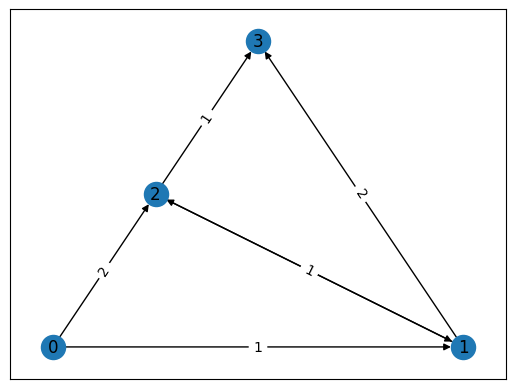

In [1]:
import networkx as nx  # noqa

nonedge = 5
graph = nx.DiGraph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 1), (2, 3)], weight=1)
graph.add_edges_from([(0, 2), (1, 3)], weight=2)
pos = nx.planar_layout(graph)
nx.draw_networkx(graph, pos=pos)

labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
distance_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=nonedge)

As with many real world problems, this task can be cast as a combinatorial optimization problem. This demo shows how to employ the Quantum Approximate Optimization Algorithm [[2](#QAOA)] on the Classiq platform to solve the Travelling Salesperson Problem.


## Mathematical Formulation

First, model the problem mathematically. The input is the set of distances between the cities: this is given by a matrix $w$, whose $(i,j)$ entry refers to the distance between city $i$ to city $j$. The output of the model is an optimized route. Any route can be captured by a binary matrix $x$ that states at each step (row) which city was visited (column):
$\begin{aligned}
x_{ij} =
\begin{cases}
      1 & \text{at time step } i \text{ the route is in city } j \\
      0 & \text{else}
\end{cases}\\
\end{aligned}$

For example:
$\begin{aligned}
x=\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0
\end{pmatrix}
\end{aligned}$ means starting from city 1, going to city 3 and then to city 2, and ending at city 0.

**The constrained optimization problem is defined as follows:**

Find x, which minimizes the path distance -
  $\begin{aligned}
\min_{x_{i, p} \in \{0, 1\}}  \Sigma_{i, j} w_{i, j} \Sigma_p x_{i, p} x_{j, p + 1}\\
\end{aligned}$

(Note that the inner sum over $p$ is simply an indicator for whether to go from city $i$ to city $j$.)

such that

- each point is visited once -
  $\begin{aligned}
\forall i, \hspace{0.2cm} \Sigma_p x_{i, p} = 1\\
\end{aligned}$

- in each step only a single point is visited -
  $\begin{aligned}
\forall p, \hspace{0.2cm} \Sigma_i x_{i, p} = 1\\
\end{aligned}$

**Directed graph:**

In some cases, such as the graph above, not all cities are connected, and it is more suitable to describe the problem with a weighted, directed graph. In this case, to find the shortest path, assume that unconnected cities have an infinite distance between them. For example, the graph above corresponds to this matrix:

$\begin{aligned}
w=\begin{pmatrix}
\infty & 1 & 2 & \infty \\
\infty & \infty & 1 & 2 \\
\infty & 1 & \infty & 1 \\
\infty & \infty & \infty & \infty
\end{pmatrix}
\end{aligned}$

In practice, choose a large enough weight rather than infinity.


## Solving with the Classiq Platform

Solve the problem with the Classiq platform using QAOA by defining a Pyomo model.


### Building the Pyomo Model from a Matrix of Distances Input


In [2]:
import numpy as np  # noqa
import pyomo.core as pyo

In [3]:
## Define a function that gets the matrix of distances and returns a Pyomo model


def PyomoTSP(dis_mat: np.ndarray) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("TSP")

    assert dis_mat.shape[0] == dis_mat.shape[1], "error distance matrix is not square"

    NofCities = dis_mat.shape[0]  # total number of cities
    cities = range(NofCities)  # list of cities

    # Define the variable, which is the binary matrix x: x[i, j] = 1 indicates that point i is visited at step j
    model.x = pyo.Var(cities, cities, domain=pyo.Binary)

    # we add constraints
    @model.Constraint(cities)
    def each_step_visits_one_point_rule(model, ii):
        return sum(model.x[ii, jj] for jj in range(NofCities)) == 1

    @model.Constraint(cities)
    def each_point_visited_once_rule(model, jj):
        return sum(model.x[ii, jj] for ii in range(NofCities)) == 1

    # Define the Objective function
    def is_connected(i1: int, i2: int):
        return sum(model.x[i1, kk] * model.x[i2, kk + 1] for kk in cities[:-1])

    model.cost = pyo.Objective(
        expr=sum(
            dis_mat[i1, i2] * is_connected(i1, i2) for i1, i2 in model.x.index_set()
        )
    )

    return model

### Generating a Specific Problem

Pick a specific problem: the graph introduced above:


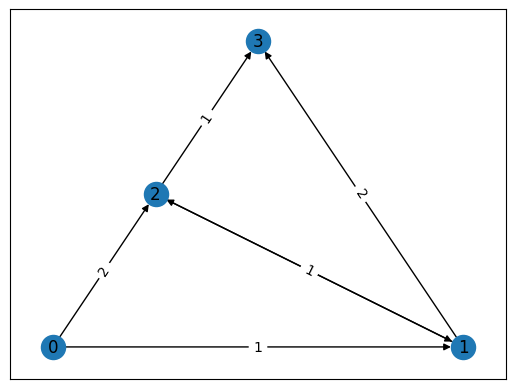

In [4]:
# Generate a graph that defines the problem
import networkx as nx

graph = nx.DiGraph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 1), (2, 3)], weight=1)
graph.add_edges_from([(0, 2), (1, 3)], weight=2)
pos = nx.planar_layout(graph)
nx.draw_networkx(graph, pos=pos)

labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels);

Convert the graph object into a matrix of distances and then generate a Pyomo model for this example:

In [5]:
nonedge = 5  # this variable refers to how much we penalize for unconnected points
distance_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=nonedge)
tsp_model = PyomoTSP(distance_matrix)

### Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the `CombinatorialProblem` Python class. Under the hood it translates the Pyomo model to a quantum model of QAOA [[1](#QAOA)], with the cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument:

In [6]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=tsp_model, num_layers=8)

qmod = combi.get_model()

In [7]:
write_qmod(qmod, "traveling_salesman_problem")

### Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [8]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2zJRXpc3YfcnB9t3wHdi4C956A7


Solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of QAOA, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of QAOA [[2](#cvar)]:

In [9]:
optimized_params = combi.optimize(maxiter=150, quantile=0.6)

Optimization Progress:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 140/150 [13:14<00:56,  5.68s/it]


Check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

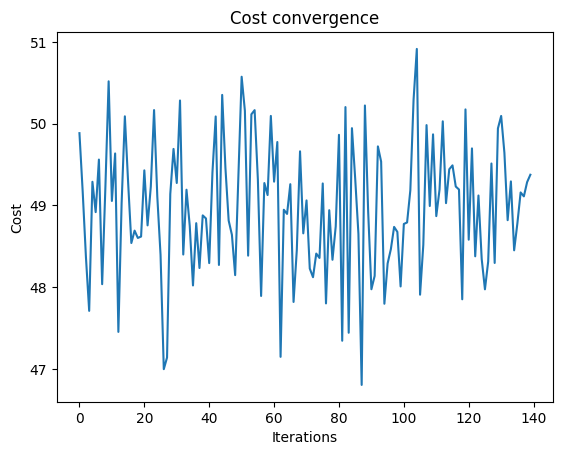

In [10]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

Examine the statistics of the algorithm. To get samples with the optimized parameters, call the `sample` method:

In [11]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
108,"{'x': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0...",0.000488,3
41,"{'x': [[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0...",0.000977,5
896,"{'x': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0...",0.000488,7
147,"{'x': [[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0...",0.000488,8
1240,"{'x': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1...",0.000488,8


Compare the optimized results with uniformly sampled results:

In [12]:
uniform_result = combi.sample_uniform()

And compare the histograms:

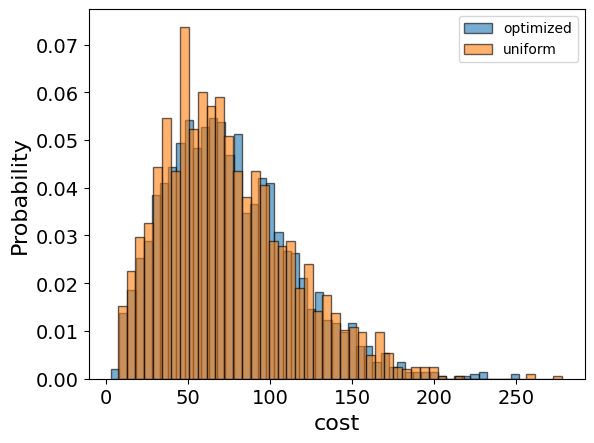

In [13]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Plot the solution:

In [14]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]}

Lastly, compare with the classical solution of the problem:

In [15]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tsp_model)

tsp_model.display()

Model TSP

  Variables:
    x : Size=16, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (2, 3) :     0 :   0.0 :     1 : False : False : Binary
        (3, 0) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1) :     0 :   0.0 :     1 : False : 

If you get the right solution, plot it:

In [16]:
best_classical_solution = np.array(
    [int(pyo.value(tsp_model.x[idx])) for idx in np.ndindex(distance_matrix.shape)]
)

In [17]:
best_quantum_solution = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]["x"]
)

The route of the traveller is: [0 1 2 3]


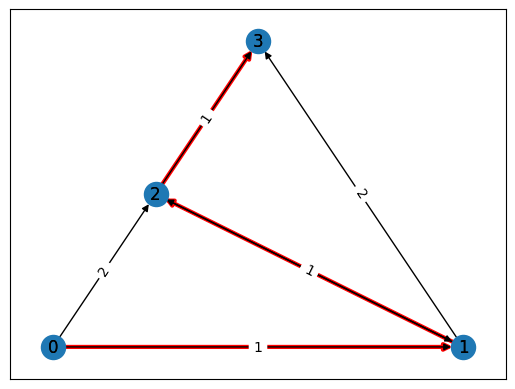

In [18]:
if (best_classical_solution == best_quantum_solution.flatten()).all():
    routesol = np.zeros(4, dtype=int)
    for k in range(4):
        routesol[k] = np.where(
            best_quantum_solution.reshape(distance_matrix.shape)[k, :] == 1
        )[0]
    edgesol = list(nx.utils.pairwise(routesol))
    nx.draw_networkx(
        graph,
        pos,
        with_labels=True,
        edgelist=edgesol,
        edge_color="red",
        node_size=200,
        width=3,
    )
    nx.draw_networkx(graph, pos=pos)

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    print("The route of the traveller is:", routesol)


## References

<a id='TSPWiki'>[1]</a> [Travelling Salesman Problem (Wikipedia).](https://en.wikipedia.org/wiki/Travelling_salesman_problem)

<a id='QAOA'>[2]</a> [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a> [Barkoutsos, Panagiotis Kl, et al. (2020). Improving variational quantum optimization using CVaR. Quantum 4: 256.](https://arxiv.org/abs/1907.04769)
